## Discover Sionna

This example notebook will guide you through the basic principles and illustrates the key features of [Sionna](https://nvlabs.github.io/sionna).
With only a few commands, you can simulate the PHY-layer link-level performance for many 5G-compliant components, including easy visualization of the results.


### Load Required Packages

The Sionna python package must be [installed](https://nvlabs.github.io/sionna/installation.html).

In [1]:
import numpy as np
import tensorflow as tf

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# IPython "magic function" for inline plots
%matplotlib inline
import matplotlib.pyplot as plt

**Tip**: you can run bash commands in Jupyter via the `!` operator.

In [11]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In case multiple GPUs are available, we restrict this notebook to single-GPU usage. You can ignore this command if only one GPU is available.

Further, we want to avoid that this notebook instantiates the whole GPU memory when initialized and set `memory_growth` as active.

*Remark*: Sionna does not require a GPU. Everything can also run on your CPU - but you may need to wait a little longer.

In [12]:
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Index of the GPU to be used
    try:
        #tf.config.set_visible_devices([], 'GPU')
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

Number of GPUs available : 0


### Sionna Data-flow and Design Paradigms

Sionna inherently parallelizes simulations via *batching*, i.e., each element in the batch dimension is simulated independently.

This means the first tensor dimension is always used for *inter-frame* parallelization similar to an outer *for-loop* in Matlab/NumPy simulations.

To keep the dataflow efficient, Sionna follows a few simple design principles:

* Signal-processing components are implemented as an individual [Keras layer](https://keras.io/api/layers/).
* `tf.float32` is used as preferred datatype and `tf.complex64` for complex-valued datatypes, respectively.
This allows simpler re-use of components (e.g., the same scrambling layer can be used for binary inputs and LLR-values).
* Models can be developed in *eager mode* allowing simple (and fast) modification of system parameters.
* Number crunching simulations can be executed in the faster *graph mode* or even *XLA* acceleration is available for most components.
* Whenever possible, components are automatically differentiable via [auto-grad](https://www.tensorflow.org/guide/autodiff) to simplify the deep learning design-flow.
* Code is structured into sub-packages for different tasks such as channel coding, mapping,... (see [API documentation](https://nvlabs.github.io/sionna/api/sionna.html) for details).

The division into individual blocks simplifies deployment and all layers and functions comes with unittests to ensure their correct behavior.

These paradigms simplify the re-useability and reliability of our components for a wide range of communications related applications.

### Let's Get Started - The First Layers (*Eager Mode*)

Every layer needs to be initialized once before it can be used.

**Tip**: use the [API documentation](https://nvlabs.github.io/sionna/api/sionna.html) to find an overview of all existing components.

We now want to transmit some symbols over an AWGN channel.
First, we need to initialize the corresponding layer.

In [13]:
channel = sionna.channel.AWGN() # init AWGN channel layer

In this first example, we want to add Gaussian noise to some given values of `x`.

Remember - the first dimension is the *batch-dimension*.

We simulate 2 message frames each containing 4 symbols.

*Remark*: the [AWGN channel](https://nvlabs.github.io/sionna/api/channel.html#awgn) is defined to be complex-valued.

In [14]:
# define a (complex-valued) tensor to be transmitted
x = tf.constant([[0., 1.5, 1., 0.],[-1., 0., -2, 3 ]], dtype=tf.complex64)

# let's have look at the shape
print("Shape of x: ", x.shape)
print("Values of x: ", x)

Shape of x:  (2, 4)
Values of x:  tf.Tensor(
[[ 0. +0.j  1.5+0.j  1. +0.j  0. +0.j]
 [-1. +0.j  0. +0.j -2. +0.j  3. +0.j]], shape=(2, 4), dtype=complex64)


We want to simulate the channel at an SNR of 5 dB.
For this, we can simply *call* the previously defined layer `channel`.

If you have never used  [Keras](https://keras.io) you can think of a layer as of a function: it has an input and returns the processed output.

*Remark*: Each time this cell is executed a new noise realization is drawn.

In [15]:
ebno_db = 5

# calculate noise variance from given EbNo
no = sionna.utils.ebnodb2no(ebno_db = ebno_db,
                            num_bits_per_symbol=2, # QPSK
                            coderate=1)
y = channel([x, no])

print("Noisy symbols are: ", y)

Noisy symbols are:  tf.Tensor(
[[-0.09735578+0.04063098j  1.6091774 +0.11160819j  0.4242279 +0.08881886j
  -0.1930846 -0.244545j  ]
 [-1.1012354 -0.02648836j  0.12208287-0.25251856j -2.2252846 +0.2471752j
   2.8859499 -0.19797805j]], shape=(2, 4), dtype=complex64)


### Batches and Multi-dimensional Tensors

Sionna natively supports multi-dimensional tensors.

Most layers operate at the last dimension and can have arbitrary input shapes (preserved at output).

Let us assume we want to add a CRC-24 check to 64 codewords of length 500 (e.g., different CRC per sub-carrier).
Further, we want to parallelize the simulation over a batch of 100 samples.

In [16]:
batch_size = 100 # outer level of parallelism
num_codewords = 64 # codewords per batch sample
info_bit_length = 500 # info bits PER codeword

source = sionna.utils.BinarySource() # yields random bits

u = source([batch_size, num_codewords, info_bit_length]) # call the source layer
print("Shape of u: ", u.shape)

# initialize an CRC encoder with the standard compliant "CRC24A" polynomial
encoder_crc = sionna.fec.crc.CRCEncoder("CRC24A")
decoder_crc = sionna.fec.crc.CRCDecoder(encoder_crc) # connect to encoder

# add the CRC to the information bits u
c = encoder_crc(u) # returns a list [c, crc_valid]
print("Shape of c: ", c.shape)
print("Processed bits: ", np.size(c.numpy()))

# we can also verify the results
# returns list of [info bits without CRC bits, indicator if CRC holds]
u_hat, crc_valid = decoder_crc(c)
print("Shape of u_hat: ", u_hat.shape)
print("Shape of crc_valid: ", crc_valid.shape)

print("Valid CRC check of first codeword: ", crc_valid.numpy()[0,0,0])

Shape of u:  (100, 64, 500)
Shape of c:  (100, 64, 524)
Processed bits:  3353600
Shape of u_hat:  (100, 64, 500)
Shape of crc_valid:  (100, 64, 1)
Valid CRC check of first codeword:  True


We want to do another simulation but for 5 independent users.

Instead of defining 5 different tensors, we can simply add another dimension.

In [17]:
num_users = 5

u = source([batch_size, num_users, num_codewords, info_bit_length])
print("New shape of u: ", u.shape)

# We can re-use the same encoder as before
c = encoder_crc(u)
print("New shape of c: ", c.shape)
print("Processed bits: ", np.size(c.numpy()))

New shape of u:  (100, 5, 64, 500)
New shape of c:  (100, 5, 64, 524)
Processed bits:  16768000


Often a good visualization of results helps to get new research ideas.
Thus, Sionna has built-in plotting functions.

Let's have look at a 16-QAM constellation.

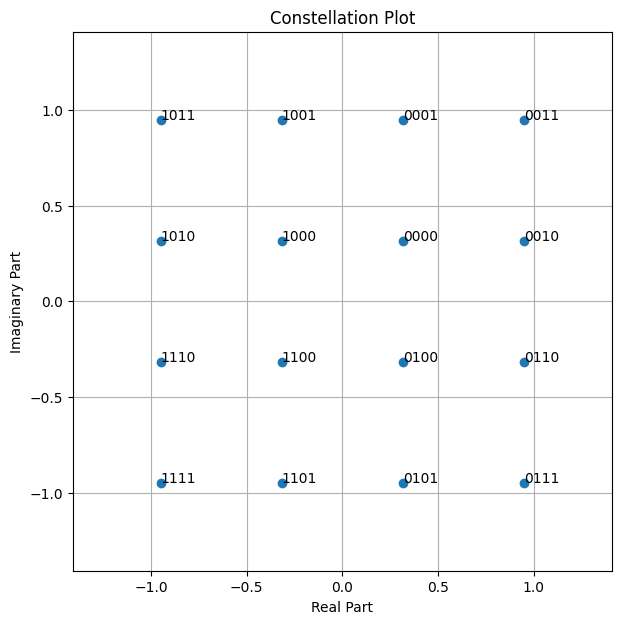

In [18]:
constellation = sionna.mapping.Constellation("qam", num_bits_per_symbol=4)
constellation.show();

### First Link-level Simulation

We can already build powerful code with a few simple commands.

As mentioned earlier, Sionna aims at hiding system complexity into Keras layers.
However, we still want to provide as much flexibility as possible.
Thus, most layers have several choices of init parameters, but often the default choice is a good start.

**Tip**: the [API documentation](https://nvlabs.github.io/sionna/api/sionna.html) provides many helpful references and implementation details.

In [19]:
# system parameters
n_ldpc = 500 # LDPC codeword length
k_ldpc = 250 # number of info bits per LDPC codeword
coderate = k_ldpc / n_ldpc
num_bits_per_symbol = 4 # number of bits mapped to one symbol (cf. QAM)

Often, several different algorithms are implemented, e.g., the demapper supports  *"true app"* demapping, but also *"max-log"* demapping.

The check-node (CN) update function of the LDPC BP decoder also supports multiple algorithms.

In [20]:
demapping_method = "app" # try "max-log"
ldpc_cn_type = "boxplus" # try also "minsum"

Let us initialize all required components for the given system parameters.

In [21]:
binary_source = sionna.utils.BinarySource()
encoder = sionna.fec.ldpc.encoding.LDPC5GEncoder(k_ldpc, n_ldpc)
constellation = sionna.mapping.Constellation("qam", num_bits_per_symbol)
mapper = sionna.mapping.Mapper(constellation=constellation)
channel = sionna.channel.AWGN()
demapper = sionna.mapping.Demapper(demapping_method,
                                   constellation=constellation)
decoder = sionna.fec.ldpc.decoding.LDPC5GDecoder(encoder,
                                                 hard_out=True, cn_type=ldpc_cn_type,
                                                 num_iter=20)

We can now run the code in *eager mode*. This allows us to modify the structure at any time - you can try a different `batch_size` or a different SNR `ebno_db`.

In [22]:
# simulation parameters
batch_size = 1000
ebno_db = 4

# Generate a batch of random bit vectors
b = binary_source([batch_size, k_ldpc])

# Encode the bits using 5G LDPC code
print("Shape before encoding: ", b.shape)
c = encoder(b)
print("Shape after encoding: ", c.shape)

# Map bits to constellation symbols
x = mapper(c)
print("Shape after mapping: ", x.shape)

# Transmit over an AWGN channel at SNR 'ebno_db'
no = sionna.utils.ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
y = channel([x, no])
print("Shape after channel: ", y.shape)

# Demap to LLRs
llr = demapper([y, no])
print("Shape after demapping: ", llr.shape)

# LDPC decoding using 20 BP iterations
b_hat = decoder(llr)
print("Shape after decoding: ", b_hat.shape)

# calculate BERs
c_hat = tf.cast(tf.less(0.0, llr), tf.float32) # hard-decided bits before dec.
ber_uncoded = sionna.utils.metrics.compute_ber(c, c_hat)

ber_coded = sionna.utils.metrics.compute_ber(b, b_hat)

print("BER uncoded = {:.3f} at EbNo = {:.1f} dB".format(ber_uncoded, ebno_db))
print("BER after decoding = {:.3f} at EbNo = {:.1f} dB".format(ber_coded, ebno_db))
print("In total {} bits were simulated".format(np.size(b.numpy())))

Shape before encoding:  (1000, 250)
Shape after encoding:  (1000, 500)
Shape after mapping:  (1000, 125)
Shape after channel:  (1000, 125)
Shape after demapping:  (1000, 500)
Shape after decoding:  (1000, 250)
BER uncoded = 0.119 at EbNo = 4.0 dB
BER after decoding = 0.011 at EbNo = 4.0 dB
In total 250000 bits were simulated


Just to summarize: we have simulated the transmission of 250,000 bits including higher-order modulation and channel coding!

But we can go even faster with the *TF graph execution*!

### Setting up the End-to-end Model

We now define a *Keras model* that is more convenient for training and Monte-Carlo simulations.

We simulate the transmission over a time-varying multi-path channel (the *TDL-A* model from 3GPP TR38.901).
For this, OFDM and a *conventional* bit-interleaved coded modulation (BICM) scheme with higher order modulation is used.
The information bits are protected by a 5G-compliant LDPC code.

*Remark*: Due to the large number of parameters, we define them as dictionary.

In [23]:
class e2e_model(tf.keras.Model): # inherits from keras.model
    """Example model for end-to-end link-level simulations.

    Parameters
    ----------
    params: dict
        A dictionary defining the system parameters.

    Input
    -----
    batch_size: int or tf.int
        The batch_sizeused for the simulation.

    ebno_db: float or tf.float
        A float defining the simulation SNR.

    Output
    ------
    (b, b_hat):
        Tuple:

    b: tf.float32
        A tensor of shape `[batch_size, k]` containing the transmitted
        information bits.

    b_hat: tf.float32
        A tensor of shape `[batch_size, k]` containing the receiver's
        estimate of the transmitted information bits.
    """
    def __init__(self,
                params):
        super().__init__()


        # Define an OFDM Resource Grid Object
        self.rg = sionna.ofdm.ResourceGrid(
                            num_ofdm_symbols=params["num_ofdm_symbols"],
                            fft_size=params["fft_size"],
                            subcarrier_spacing=params["subcarrier_spacing"],
                            num_tx=1,
                            num_streams_per_tx=1,
                            cyclic_prefix_length=params["cyclic_prefix_length"],
                            pilot_pattern="kronecker",
                            pilot_ofdm_symbol_indices=params["pilot_ofdm_symbol_indices"])

        # Create a Stream Management object
        self.sm = sionna.mimo.StreamManagement(rx_tx_association=np.array([[1]]),
                                               num_streams_per_tx=1)

        self.coderate = params["coderate"]
        self.num_bits_per_symbol = params["num_bits_per_symbol"]
        self.n = int(self.rg.num_data_symbols*self.num_bits_per_symbol)
        self.k = int(self.n*coderate)

        # Init layers
        self.binary_source = sionna.utils.BinarySource()
        self.encoder = sionna.fec.ldpc.encoding.LDPC5GEncoder(self.k, self.n)
        self.interleaver = sionna.fec.interleaving.RowColumnInterleaver(
                                        row_depth=self.num_bits_per_symbol)
        self.deinterleaver = sionna.fec.interleaving.Deinterleaver(self.interleaver)
        self.mapper = sionna.mapping.Mapper("qam", self.num_bits_per_symbol)
        self.rg_mapper = sionna.ofdm.ResourceGridMapper(self.rg)
        self.tdl = sionna.channel.tr38901.TDL(model="A",
                           delay_spread=params["delay_spread"],
                           carrier_frequency=params["carrier_frequency"],
                           min_speed=params["min_speed"],
                           max_speed=params["max_speed"])

        self.channel = sionna.channel.OFDMChannel(self.tdl, self.rg, add_awgn=True, normalize_channel=True)
        self.ls_est = sionna.ofdm.LSChannelEstimator(self.rg, interpolation_type="nn")
        self.lmmse_equ = sionna.ofdm.LMMSEEqualizer(self.rg, self.sm)
        self.demapper = sionna.mapping.Demapper(params["demapping_method"],
                                                "qam", self.num_bits_per_symbol)
        self.decoder = sionna.fec.ldpc.decoding.LDPC5GDecoder(self.encoder,
                                                    hard_out=True,
                                                    cn_type=params["cn_type"],
                                                    num_iter=params["bp_iter"])

        print("Number of pilots: {}".format(self.rg.num_pilot_symbols))
        print("Number of data symbols: {}".format(self.rg.num_data_symbols))
        print("Number of resource elements: {}".format(
                                    self.rg.num_resource_elements))

        print("Pilot overhead: {:.2f}%".format(
                                    self.rg.num_pilot_symbols /
                                    self.rg.num_resource_elements*100))

        print("Cyclic prefix overhead: {:.2f}%".format(
                                    params["cyclic_prefix_length"] /
                                    (params["cyclic_prefix_length"]
                                    +params["fft_size"])*100))

        print("Each frame contains {} information bits".format(self.k))

    def call(self, batch_size, ebno_db):

        # Generate a batch of random bit vectors
        # We need two dummy dimension representing the number of
        # transmitters and streams per transmitter, respectively.
        b = self.binary_source([batch_size, 1, 1, self.k])

        # Encode the bits using the all-zero dummy encoder
        c = self.encoder(b)

        # Interleave the bits before mapping (BICM)
        c_int = self.interleaver(c)

        # Map bits to constellation symbols
        s = self.mapper(c_int)

        # Map symbols onto OFDM ressource grid
        x_rg = self.rg_mapper(s)

        # Transmit over noisy multi-path channel
        no = sionna.utils.ebnodb2no(ebno_db, self.num_bits_per_symbol, self.coderate, self.rg)
        y = self.channel([x_rg, no])

        # LS Channel estimation with nearest pilot interpolation
        h_hat, err_var = self.ls_est ([y, no])

        # LMMSE Equalization
        x_hat, no_eff = self.lmmse_equ([y, h_hat, err_var, no])

        # Demap to LLRs
        llr = self.demapper([x_hat, no_eff])

        # Deinterleave before decoding
        llr_int = self.deinterleaver(llr)

        # Decode
        b_hat = self.decoder(llr_int)

        # number of simulated bits
        nb_bits = batch_size*self.k

        # transmitted bits and the receiver's estimate after decoding
        return b, b_hat

Let us define the system parameters for our simulation as dictionary:

In [24]:
sys_params = {
    # Channel
    "carrier_frequency" : 3.5e9,
    "delay_spread" : 100e-9,
    "min_speed" : 3,
    "max_speed" : 3,
    "tdl_model" : "A",

    # OFDM
    "fft_size" : 256,
    "subcarrier_spacing" : 30e3,
    "num_ofdm_symbols" : 14,
    "cyclic_prefix_length" : 16,
    "pilot_ofdm_symbol_indices" : [2, 11],

    # Code & Modulation
    "coderate" : 0.5,
    "num_bits_per_symbol" : 4,
    "demapping_method" : "app",
    "cn_type" : "boxplus",
    "bp_iter" : 20
}

...and initialize the model:

In [25]:
model = e2e_model(sys_params)

Number of pilots: 512
Number of data symbols: 3072
Number of resource elements: 3584
Pilot overhead: 14.29%
Cyclic prefix overhead: 5.88%
Each frame contains 6144 information bits


As before, we can simply *call* the model to simulate the BER for the given simulation parameters.

In [26]:
#simulation parameters
ebno_db = 10
batch_size = 200

# and call the model
b, b_hat = model(batch_size, ebno_db)

ber = sionna.utils.metrics.compute_ber(b, b_hat)
nb_bits = np.size(b.numpy())

print("BER: {:.4} at Eb/No of {} dB and {} simulated bits".format(ber.numpy(), ebno_db, nb_bits))

BER: 0.001849 at Eb/No of 10 dB and 1228800 simulated bits


### Run some Throughput Tests (Graph Mode)

Sionna is not just an easy-to-use library, but also incredibly fast.
Let us measure the throughput of the model defined above.

We compare *eager* and *graph* execution modes (see [Tensorflow Doc](https://www.tensorflow.org/guide/intro_to_graphs) for details), as well
as *eager with XLA* (see https://www.tensorflow.org/xla#enable_xla_for_tensorflow_models).
Note that we need to activate the [sionna.config.xla_compat](https://nvlabs.github.io/sionna/api/config.html#sionna.Config.xla_compat) feature for XLA to work.


**Tip**: change the `batch_size` to see how the batch parallelism enhances the throughput.
Depending on your machine, the `batch_size` may be too large.

In [27]:
import time # this block requires the timeit library

batch_size = 200
ebno_db = 5 # evalaute SNR point
repetitions = 4 # throughput is averaged over multiple runs

def get_throughput(batch_size, ebno_db, model, repetitions=1):
    """ Simulate throughput in bit/s per ebno_db point.

    The results are average over `repetition` trials.

    Input
    -----
    batch_size: int or tf.int32
        Batch-size for evaluation.

    ebno_db: float or tf.float32
        A tensor containing the SNR points be evaluated

    model:
        Function or model that yields the transmitted bits `u` and the
        receiver's estimate `u_hat` for a given ``batch_size`` and
        ``ebno_db``.

    repetitions: int
        An integer defining how many trails of the throughput
        simulation are averaged.

    """


    # call model once to be sure it is compile properly
    # otherwise time to build graph is measured as well.
    u, u_hat = model(tf.constant(batch_size, tf.int32),
                     tf.constant(ebno_db, tf.float32))

    t_start = time.perf_counter()
    # average over multiple runs
    for _ in range(repetitions):
        u, u_hat = model(tf.constant(batch_size, tf.int32),
                            tf.constant(ebno_db, tf. float32))
    t_stop = time.perf_counter()

    # throughput in bit/s
    throughput = np.size(u.numpy())*repetitions / (t_stop - t_start)

    return throughput

# eager mode - just call the model
def run_eager(batch_size, ebno_db):
    return model(batch_size, ebno_db)

time_eager = get_throughput(batch_size, ebno_db, run_eager, repetitions=4)

# the decorator "@tf.function" enables the graph mode
@tf.function
def run_graph(batch_size, ebno_db):
    return model(batch_size, ebno_db)

time_graph = get_throughput(batch_size, ebno_db, run_graph, repetitions=4)

# the decorator "@tf.function(jit_compile=True)" enables the graph mode with XLA
# we need to activate the sionna.config.xla_compat feature for this to work
sionna.config.xla_compat=True
@tf.function(jit_compile=True)
def run_graph_xla(batch_size, ebno_db):
    return model(batch_size, ebno_db)

time_graph_xla = get_throughput(batch_size, ebno_db, run_graph_xla, repetitions=4)
# we deactivate the sionna.config.xla_compat so that the cell can be run mutiple times
sionna.config.xla_compat=False

print(f"Throughput in eager execution: {time_eager/1e6:.2f} Mb/s")
print(f"Throughput in graph execution: {time_graph/1e6:.2f} Mb/s")
print(f"Throughput in graph execution with XLA: {time_graph_xla/1e6:.2f} Mb/s")

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Throughput in eager execution: 0.05 Mb/s
Throughput in graph execution: 0.09 Mb/s
Throughput in graph execution with XLA: 0.33 Mb/s


Obviously, *graph* execution (with XLA) yields much higher throughputs (at least if a fast GPU is available).
Thus, for exhaustive training and Monte-Carlo simulations the *graph* mode (with XLA and GPU acceleration) is the preferred choice.

### Bit-Error Rate (BER) Monte-Carlo Simulations

Monte-Carlo simulations are omnipresent in todays communications research and development.
Due its performant implementation, Sionna can be directly used to simulate BER at a performance that competes with compiled languages -- but still keeps the flexibility of a script language.

In [ ]:
ebno_dbs = np.arange(0, 15, 1.)
batch_size = 200 # reduce in case you receive an out-of-memory (OOM) error

max_mc_iter = 1000 # max number of Monte-Carlo iterations before going to next SNR point
num_target_block_errors = 500 # continue with next SNR point after target number of block errors

# we use the built-in ber simulator function from Sionna which uses and early stop after reaching num_target_errors
sionna.config.xla_compat=True
ber_mc,_ = sionna.utils.sim_ber(run_graph_xla, # you can also evaluate the model directly
                                ebno_dbs,
                                batch_size=batch_size,
                                num_target_block_errors=num_target_block_errors,
                                max_mc_iter=max_mc_iter,
                                verbose=True) # print status and summary
sionna.config.xla_compat=False

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 3.4249e-01 | 1.0000e+00 |     1262550 |     3686400 |          600 |         600 |        14.9 |reached target block errors
      1.0 | 3.1945e-01 | 1.0000e+00 |     1177625 |     3686400 |          600 |         600 |        22.9 |reached target block errors
      2.0 | 2.9811e-01 | 1.0000e+00 |     1098961 |     3686400 |          600 |         600 |        11.8 |reached target block errors
      3.0 | 2.7315e-01 | 1.0000e+00 |     1006929 |     3686400 |          600 |         600 |        11.8 |reached target block errors
      4.0 | 2.4814e-01 | 1.0000e+00 |      914761 |     3686400 |          600 |         600 |        11.8 |reached target block errors
      5.0 | 2.1836e-01 | 1.0000e+00 |      804962 |     3686400 |

Let's look at the results.

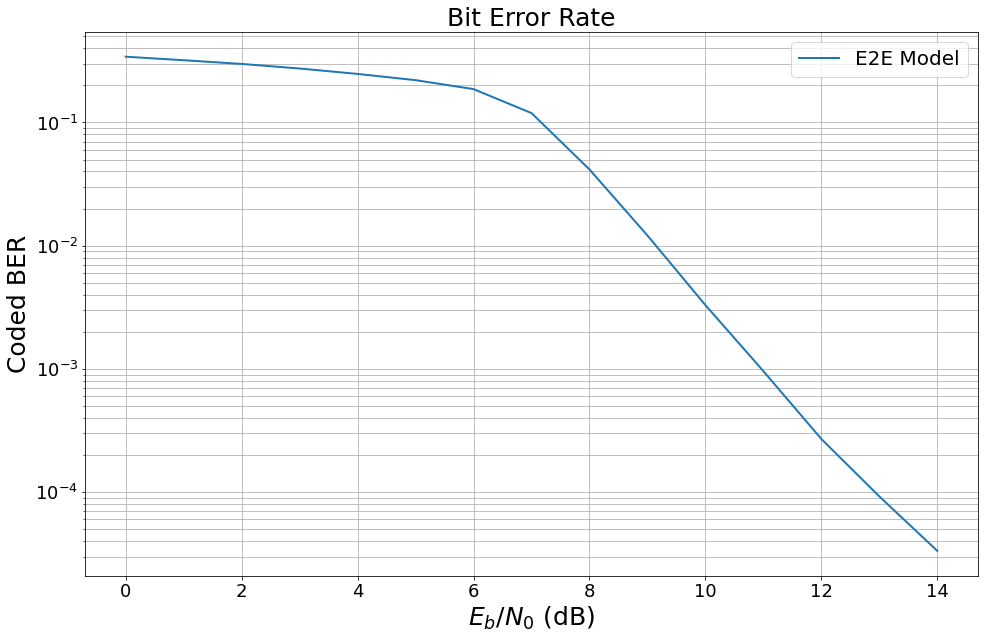

In [ ]:
sionna.utils.plotting.plot_ber(ebno_dbs,
                               ber_mc,
                               legend="E2E Model",
                               ylabel="Coded BER");

### Conclusion

We hope you are excited about Sionna - there is much more to be discovered:

- TensorBoard debugging available
- Scaling to multi-GPU simulation is simple
- See the [available tutorials](https://nvlabs.github.io/sionna/tutorials.html) for more advanced examples.

And if something is still missing - the project is [open-source](https://github.com/nvlabs/sionna/):  you can modify, add, and extend any component at any time.